# Biblioteke

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates, gaussian_filter
from skimage import io, util, exposure, color, filters, transform, img_as_ubyte
from skimage.color import rgb2gray

In [8]:
folder = "TrainingSamples"
images = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".jpg")]

img1 = cv2.imread(images[0], cv2.IMREAD_GRAYSCALE)

img2 = cv2.imread(images[2])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB) 

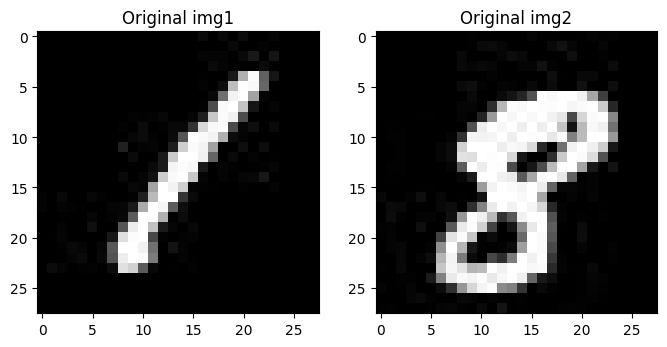

In [186]:
fig = plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.imshow(img1, cmap="gray")
plt.title("Original img1")

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title("Original img2")

plt.show()

## Tehnike augmentacije

### Okretanje (*Flipping*)

In [136]:
def flip(img, leftRight=True):
    if leftRight:
        return np.fliplr(img) 
    else:
        return np.flipud(img) 

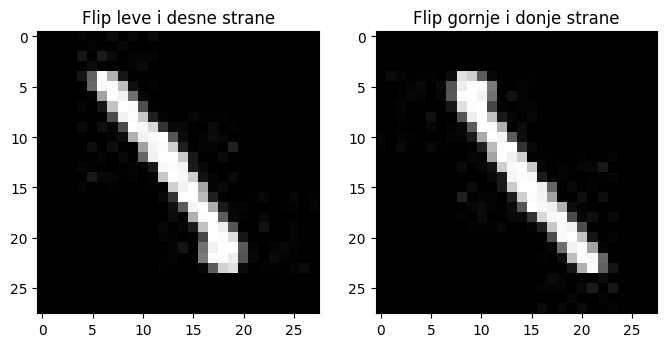

In [138]:
fig = plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.imshow(flip(img1), cmap="gray")
plt.title("Flip leve i desne strane")

plt.subplot(1,2,2)
plt.imshow(flip(img1, leftRight=False), cmap="gray")
plt.title("Flip gornje i donje strane")

plt.show()

Flipovanje **rukom pisanih cifara** može biti **nebezbedna**, iako nije vidljivo na konkretnom primeru.

---

**Gubitak semantičkog značenja cifara**

Rukom pisane cifre imaju **određenu orijentaciju**, i flipovanjem se ta orijentacija menja, što može:
- **izmeniti značenje cifre**
- ili je učiniti **neprepoznatljivom**

**Konkretni primeri:**

- **Horizontalni flip:**
  - Cifra **2** može izgledati kao izvrnuta cifra **5**
  - Cifra **6** može izgledati kao **9**
  - Cifra **3** može ličiti na **Ɛ** (obrnuto "3")

- **Vertikalni flip:**
  - Cifra **6** može postati vrlo slična **9**
  - Cifra **7** može izgubiti prepoznatljivu strukturu zbog promene smera kose crte

### Prostor boja (*Color space*)

In [196]:
def isolate_color_channel(img, color_channel='red'):
    img_copy = np.zeros_like(img) 
    
    channel_idx = {'red': 0, 'green': 1, 'blue': 2}
    
    idx = channel_idx[color_channel]
    img_copy[:, :, idx] = img[:, :, idx] 
    
    return img_as_ubyte(img_copy)

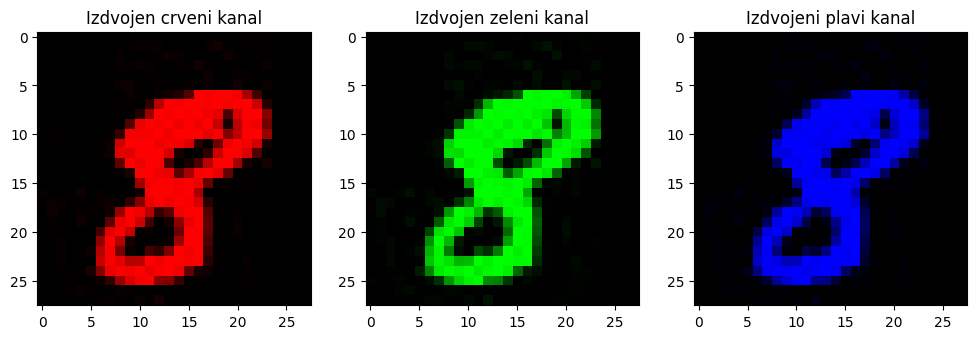

In [198]:
fig = plt.figure(figsize=(12, 4))

plt.subplot(1,3,1)
plt.imshow(isolate_color_channel(img2))
plt.title("Izdvojen crveni kanal")

plt.subplot(1,3,2)
plt.imshow(isolate_color_channel(img2, color_channel='green'))
plt.title("Izdvojen zeleni kanal")

plt.subplot(1,3,3)
plt.imshow(isolate_color_channel(img2, color_channel='blue'))
plt.title("Izdvojeni plavi kanal")

plt.show()

### Isecanje (*Cropping*)

In [65]:
def crop(img, top, left, height, width):
    return img[top:top+height, left:left+width]

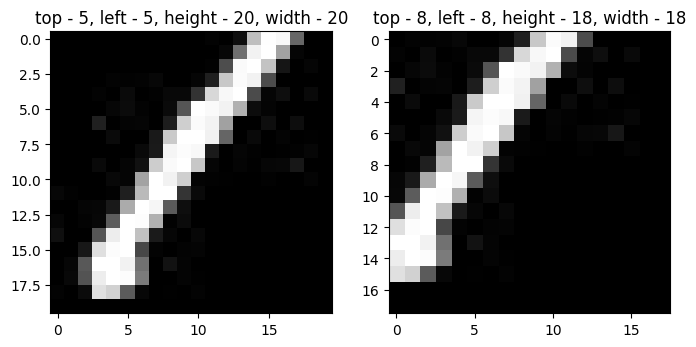

In [159]:
fig = plt.figure(figsize=(8, 4))

plt.subplot(1,2,1)
plt.imshow(crop(img1, 5, 5, 20, 20), cmap="gray")
plt.title("top - 5, left - 5, height - 20, width - 20")

plt.subplot(1,2,2)
plt.imshow(crop(img1, 8, 8, 18, 18), cmap="gray")
plt.title("top - 8, left - 8, height - 18, width - 18")

plt.show()

### Rotacija (*Rotation*)

In [27]:
def rotate(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1.0)
    return cv2.warpAffine(img, M, (w, h))

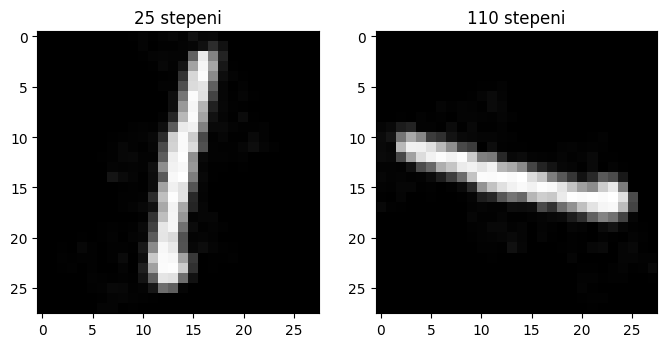

In [36]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(rotate(img1, 25), cmap="gray")
plt.title("25 stepeni")

plt.subplot(1,2,2)
plt.imshow(rotate(img1, 110), cmap="gray")
plt.title("110 stepeni")

plt.show()

Rotaciju treba primenjivati **pažljivo i u ograničenim granicama**.

---

**Veliki ugao rotacije može promeniti izgled cifre**

Može doći do:

- **Izgubljene čitljivosti cifre**
- **Sličnosti sa drugom cifrom**
- **Zbunjenosti modela tokom treniranja**

**Konkretni primeri:**

- Cifra **1** rotirana za 90° (u prikazanom primeru je ugao veći jer je broj već bio malo rotiran u originalu) može izgledati kao **—** (vodoravna linija)
- Cifra **6** rotirana za 180° izgleda kao **9**
- Cifra **0** i dalje izgleda isto, što može zbuniti model ako se ne rotiraju i druge cifre

### Translacija (*Translation*)

In [47]:
def translate(img, tx, ty): # Popuna konstantnom vrednošću 0
    
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

In [43]:
import numpy as np
import cv2
from sklearn.utils import check_random_state

def translate_with_gaussian_padding(img, tx, ty, noise_std=25, random_state=None): #noise_std: Standardna devijacija Gaussovog šuma
    
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    translated = translate(img, tx, ty)

    if img.ndim == 2: # Detekcija "crnih" piksela (tj. gde je padding sa nulom)
        mask = (translated == 0)
    else:
        mask = np.all(translated == [0, 0, 0], axis=-1)

    rng = check_random_state(random_state) # Dodavanje Gaussovog šuma u te piksele
    
    if img.ndim == 2:  # Grayscale
        noise = rng.normal(loc=0, scale=noise_std, size=img.shape).astype(np.float32)
        result = translated.astype(np.float32)
        result[mask] = noise[mask]
    else:  # RGB slika
        noise = rng.normal(loc=0, scale=noise_std, size=img.shape).astype(np.float32)
        result = translated.astype(np.float32)
        for c in range(3):
            result[..., c][mask] = noise[..., c][mask]

    result = np.clip(result, 0, 255).astype(np.uint8) # Konverzija nazad u uint8

    return result


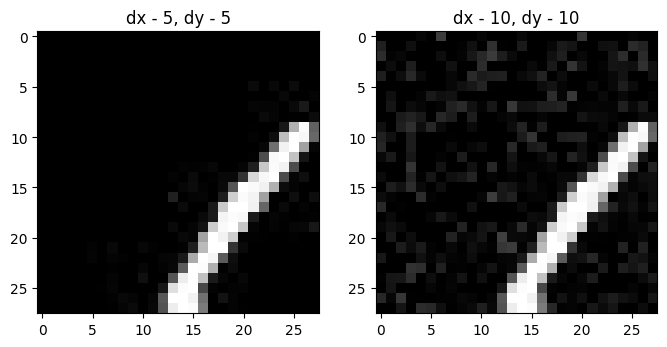

In [45]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(translate(img1, 5, 5), cmap="gray")
plt.title("dx - 5, dy - 5")

plt.subplot(1,2,2)
plt.imshow(translate_with_gaussian_padding(img1, 5, 5), cmap="gray")
plt.title("dx - 10, dy - 10")

plt.show()

### Uvođenje šuma (*Noise Injection*)

In [171]:
def add_noise(img, mode="gaussian"):
    return util.random_noise(img, mode=mode)

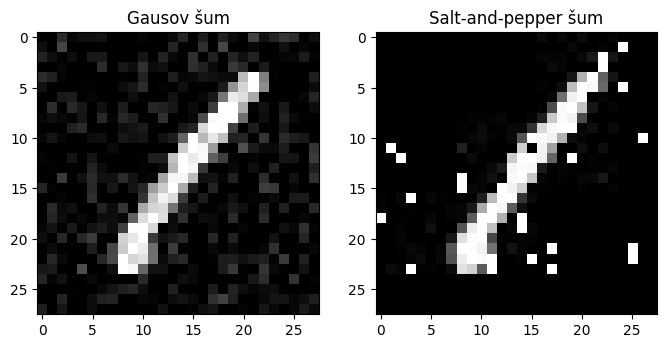

In [181]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(add_noise(img1, mode="gaussian"), cmap="gray")
plt.title("Gausov šum")

plt.subplot(1,2,2)
plt.imshow(add_noise(img1, mode="s&p"), cmap="gray")
plt.title("Salt-and-pepper šum")

plt.show()

### Transformacije u kolornom prostoru (*Color Space Transformations*)

In [200]:
def increase_contrast(img, factor=1.2): # kontrast +20%
    img_float = img.astype(np.float32) / 255.0
    mean = np.mean(img_float)
    contrasted = (img_float - mean) * factor + mean
    contrasted = np.clip(contrasted, 0, 1)
    return img_as_ubyte(contrasted)

def histogram_equalization(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])  # izhednači V kanal
    equalized = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return equalized

def white_balance(img):
    img_float = img.astype(np.float32)
    avg_b = np.mean(img_float[:, :, 0])
    avg_g = np.mean(img_float[:, :, 1])
    avg_r = np.mean(img_float[:, :, 2])
    avg_gray = (avg_b + avg_g + avg_r) / 3

    img_float[:, :, 0] *= avg_gray / avg_b
    img_float[:, :, 1] *= avg_gray / avg_g
    img_float[:, :, 2] *= avg_gray / avg_r

    img_float = np.clip(img_float, 0, 255)
    return img_float.astype(np.uint8)

def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(img, -1, kernel)
    return sharpened

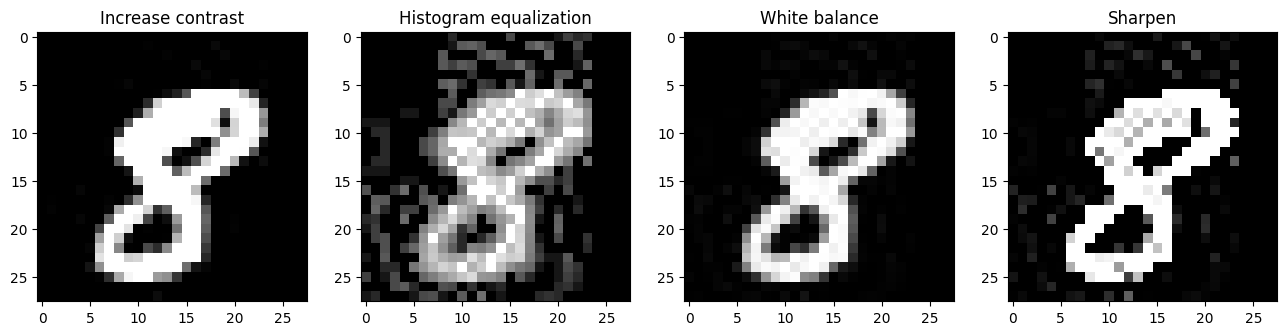

In [210]:
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.imshow(increase_contrast(img2))
plt.title("Increase contrast")

plt.subplot(1,4,2)
plt.imshow(histogram_equalization(img2))
plt.title("Histogram equalization")

plt.subplot(1,4,3)
plt.imshow(white_balance(img2))
plt.title("White balance")

plt.subplot(1,4,4)
plt.imshow(sharpen_image(img2))
plt.title("Sharpen")

plt.show()

### Kernel filtri

In [213]:
def gaussian_blur(img):
    return filters.gaussian(img, sigma=1)

def apply_sobel(img): # filter za ivice visokog kontrasta
    return filters.sobel(img)

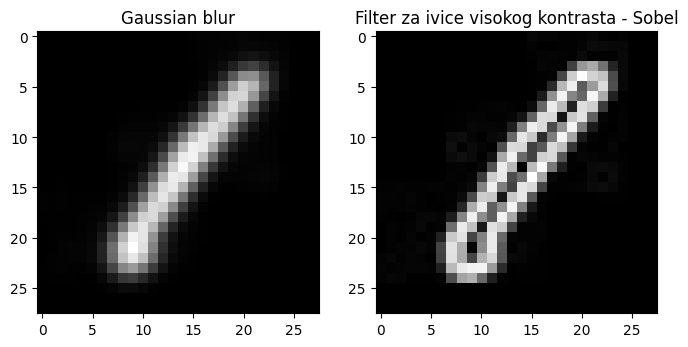

In [221]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(gaussian_blur(img1), cmap="gray")
plt.title("Gaussian blur")

plt.subplot(1,2,2)
plt.imshow(apply_sobel(img1), cmap="gray")
plt.title("Filter za ivice visokog kontrasta - Sobel")

plt.show()

### Mešanje slika

In [234]:
def mix_images(img1, img2, alpha=0.5):
    img1_float = img1.astype(np.float32) / 255.0
    img2_float = img2.astype(np.float32) / 255.0
    img1_float = transform.resize(img1_float, img2_float.shape) 
    return (alpha * img1_float + (1 - alpha) * img2_float)

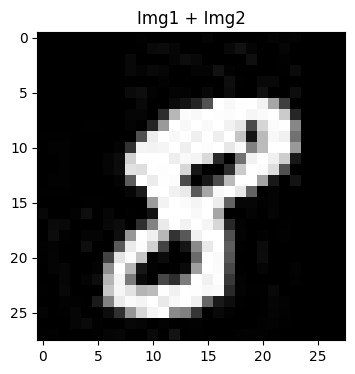

In [238]:
img1RGB = cv2.imread(images[2])
img1RGB = cv2.cvtColor(img1RGB, cv2.COLOR_BGR2RGB) 

plt.figure(figsize=(4,4))

plt.imshow(mix_images(img1RGB, img2))
plt.title("Img1 + Img2")

plt.show()

***mixing images* nema mnogo smisla za rukom pisane cifre**

**Cifre imaju jasno definisane klase**

Svaka slika prikazuje **jednu cifru** (npr. `0`, `1`, `2`, itd). Mešanjem dve slike (npr. `3` i `7`), dobija se **nepostojeća, nejasna cifra**:

- Takva slika **ne postoji u stvarnosti** (ne vidi se na primeru iznad)
- **Nema semantičko značenje**
- Model uči da slika može pripadati **dvema klasama istovremeno**, što nije tačno

### Slučajno brisanje (*Random Erasing*)

In [81]:
def random_erasing(img, erase_size=10):
    h, w = img.shape[:2]
    x = np.random.randint(0, w - erase_size)
    y = np.random.randint(0, h - erase_size)
    img_copy = img.copy()
    img_copy[y:y+erase_size, x:x+erase_size] = 0
    return img_copy

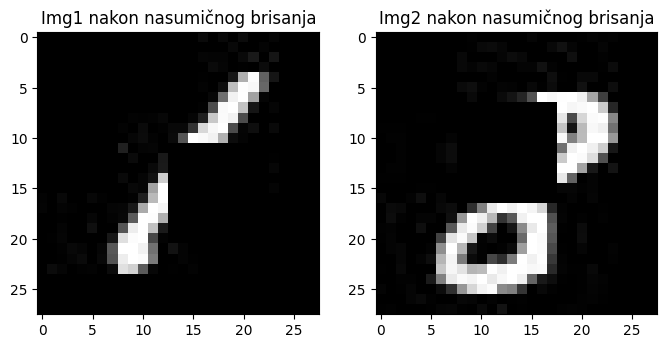

In [252]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(random_erasing(img1, erase_size=10), cmap="gray")
plt.title("Img1 nakon nasumičnog brisanja")

plt.subplot(1,2,2)
plt.imshow(random_erasing(img2, erase_size=10))
plt.title("Img2 nakon nasumičnog brisanja")

plt.show()

Ako je važan deo cifre prekriven ili uklonjen, model dobija **nepotpune informacije**, što može dovesti do:

- **Pogrešne klasifikacije**
- Težeg učenja pravilnih karakteristika cifara

---

Primer:
- Na *Img2* je mogao da se prekrije deo tako da **8** izgleda kao **6**

### Elastična distorzija

In [52]:
def elastic_distortion(image, alpha, sigma, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha # izglađivanje nasumicnih vrednosti gausijanom
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    distorted = map_coordinates(image, indices, order=1, mode='reflect') # order je 1 za bilinearnu inteprolaciju
    return distorted.reshape(image.shape)

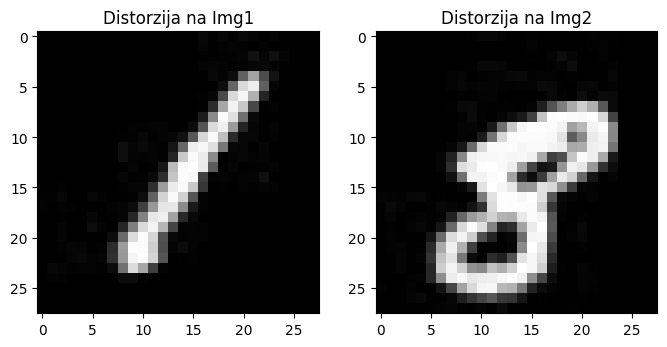

In [263]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(elastic_distortion(img1, alpha=36, sigma=6), cmap="gray")
plt.title("Distorzija na Img1")

plt.subplot(1,2,2)
plt.imshow(elastic_distortion(rgb2gray(img2), alpha=36, sigma=6), cmap="gray")
plt.title("Distorzija na Img2")

plt.show()

### Centriranje

In [9]:
def center_image(img, new_size=40):
    h, w = img.shape[:2]
    canvas = np.zeros((new_size, new_size), dtype=img.dtype)
    x_offset = (new_size - w) // 2
    y_offset = (new_size - h) // 2
    canvas[y_offset:y_offset+h, x_offset:x_offset+w] = img
    return cv2.resize(canvas, (w, h))

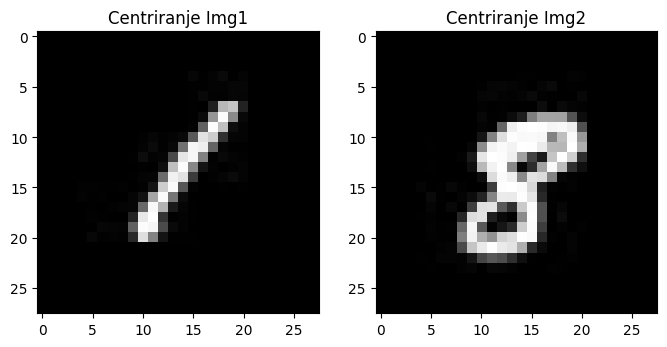

In [270]:
plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(center_image(img1), cmap="gray")
plt.title("Centriranje Img1")

plt.subplot(1,2,2)
plt.imshow(center_image(rgb2gray(img2)), cmap="gray")
plt.title("Centriranje Img2")

plt.show()

### Kombinovanje augmentacija

> Elastična distorzija + Centriranje

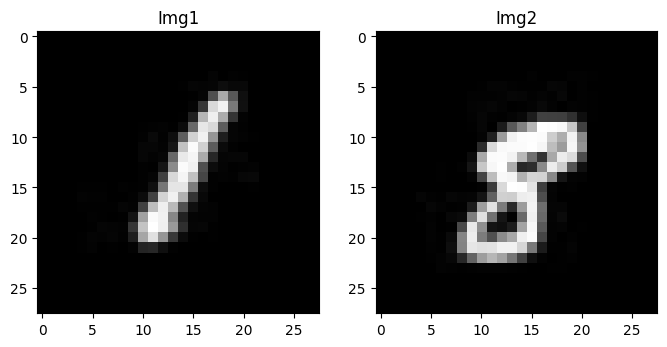

In [283]:
dist_img1 = elastic_distortion(img1, alpha=36, sigma=6)
dist_and_cent_img1 = center_image(dist_img1)

dist_img2 = elastic_distortion(rgb2gray(img2), alpha=36, sigma=6)
dist_and_cent_img2 = center_image(dist_img2)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(dist_and_cent_img1, cmap="gray")
plt.title("Img1")

plt.subplot(1,2,2)
plt.imshow(dist_and_cent_img2, cmap="gray")
plt.title("Img2")

plt.show()

> Rotacija + Elastična distorzija + Centriranje

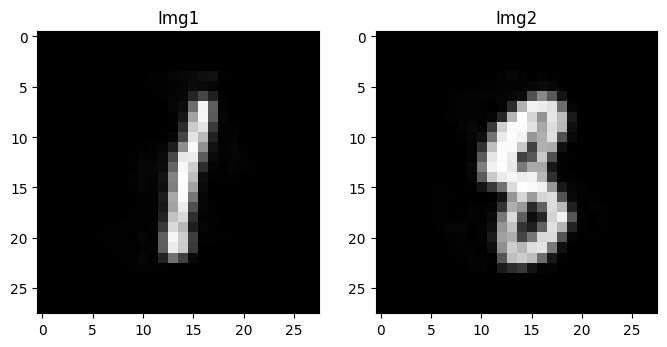

In [285]:
rot_img1 = rotate(img1, 25)
dist_and_rot_img1 = elastic_distortion(rot_img1, alpha=36, sigma=6)
cent_dist_and_rot_img1 = center_image(dist_and_rot_img1)

rot_img2 = rotate(img2, 25)
dist_and_rot_img2 = elastic_distortion(rgb2gray(rot_img2), alpha=36, sigma=6)
cent_dist_and_rot_img2 = center_image(dist_and_rot_img2)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(cent_dist_and_rot_img1, cmap="gray")
plt.title("Img1")

plt.subplot(1,2,2)
plt.imshow(cent_dist_and_rot_img2, cmap="gray")
plt.title("Img2")

plt.show()

> Translacija + Rotacija

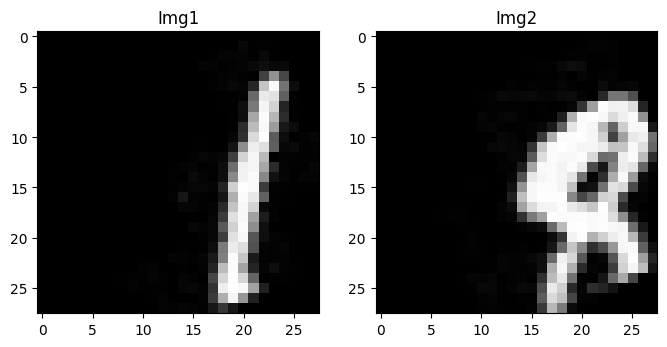

In [287]:
tran_img1 = translate(img1, 5, 5)
rot_tran_img1 = rotate(tran_img1, 25)

tran_img2 = translate(img2, 5, 5)
rot_tran_img2 = rotate(tran_img2, 25)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(rot_tran_img1, cmap="gray")
plt.title("Img1")

plt.subplot(1,2,2)
plt.imshow(rot_tran_img2, cmap="gray")
plt.title("Img2")

plt.show()

> Elastična distorzija + Elastična distorzija

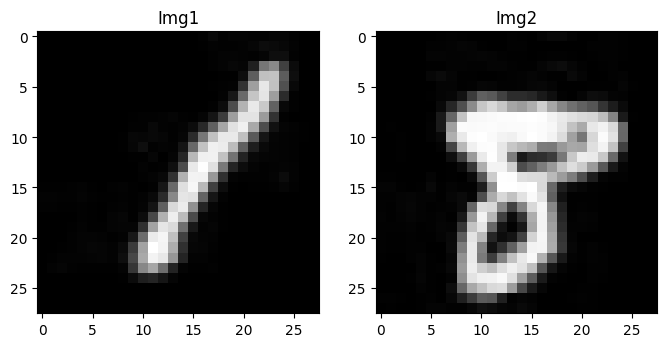

In [291]:
dist_img1 = elastic_distortion(img1, alpha=36, sigma=6)
dist2_img1 = elastic_distortion(dist_img1, alpha=36, sigma=6)

dist_img2 = elastic_distortion(rgb2gray(img2), alpha=36, sigma=6)
dist2_img2 = elastic_distortion(dist_img2, alpha=36, sigma=6)

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(dist2_img1, cmap="gray")
plt.title("Img1")

plt.subplot(1,2,2)
plt.imshow(dist2_img2, cmap="gray")
plt.title("Img2")

plt.show()